# Daily data processing and updating

Every day this script will download the daily updated file on collected information on cases and deaths due to the COVID-19 virus, courtesy of https://ourworldindata.org/coronavirus-source-data.

After downloading the file manually and placing it in the correct folder I can run this notebook once fully to convert the data to a few dataframes that I will be working with.

Namely for for each country and date that there is information about I will 4 dataframes each containing the following attributes: new cases, new deaths, total cases, total deaths

I will comment on all steps what is happening and regularly print what we're working with for transparency.

### Data import


First we'll need to collect the data, which will be saved in the same directory as this sheet.

In [123]:
import pandas as pd
import data_tools as tools
import datetime

df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide-2020-03-23.xlsx")
df

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-23,23,3,2020,10,0,Afghanistan,AF
1,2020-03-22,22,3,2020,0,0,Afghanistan,AF
2,2020-03-21,21,3,2020,2,0,Afghanistan,AF
3,2020-03-20,20,3,2020,0,0,Afghanistan,AF
4,2020-03-19,19,3,2020,0,0,Afghanistan,AF
...,...,...,...,...,...,...,...,...
6363,2020-03-20,20,3,2020,0,0,Zambia,ZM
6364,2020-03-19,19,3,2020,2,0,Zambia,ZM
6365,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW
6366,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW


### Data processing

As a first step we will clean out th data a bit since we have quite some values that we do not need.

Considering the 'DateRep' column contains a datetime that Python can translate we will delete the unneeded time attributes as well as the geoid's since we will not be using them.

In [124]:
df = df.drop(columns=['Day', 'Month', 'Year', 'GeoId'])
df

,DateRep,Cases,Deaths,Countries and territories
0,2020-03-23,10,0,Afghanistan
1,2020-03-22,0,0,Afghanistan
2,2020-03-21,2,0,Afghanistan
3,2020-03-20,0,0,Afghanistan
4,2020-03-19,0,0,Afghanistan
...,...,...,...,...
6363,2020-03-20,0,0,Zambia
6364,2020-03-19,2,0,Zambia
6365,2020-03-23,0,0,Zimbabwe
6366,2020-03-22,1,0,Zimbabwe


Next, just to make our next step a little bit easier we will create two lists. One for every date and another for every country that can be found in the database.

In [190]:
dates = []
countries = []

for entry in df['DateRep']:
    if entry not in dates:
        dates.append(entry)

for entry in df['Countries and territories']:
    if entry not in countries:
        countries.append(entry)
        
dates.sort()

Now for the actual data extraction. 
We will start with the new cases and deaths and continue from there.

To create the structures of our dataframes we will make a list filled with tuples, which in turn contain the name of the columns we will create (in this case the 'Date' and all country names) followed by a list that holds the values of cases or deaths of that country. 
We will always follow the order of the dates list we created before when filling the lists of country values to they all line up.

At the end we convert those structure lists into dictionaries to be able to use pandas on them and convert them into dataframes.

In [191]:
structure_cases = [('Date', dates)]
structure_deaths = [('Date', dates)]
i = 1

for country in countries:
    structure_cases.append((country, []))
    structure_deaths.append((country, []))
    
    country_df = df.loc[df['Countries and territories']==country]
    collected_dates = country_df['DateRep'].tolist()
    
    for date in dates:
        if date in collected_dates:
            entry = country_df.loc[country_df['DateRep']==date]
            structure_cases[i][1].append(entry['Cases'].values[0])
            structure_deaths[i][1].append(entry['Deaths'].values[0])
            
        else:
            structure_cases[i][1].append(0)
            structure_deaths[i][1].append(0)
    
    i += 1

dict_cases = {title: content for (title, content) in structure_cases}
dict_deaths = {title: content for (title, content) in structure_deaths}

New we're finlly ready to create the dataframes for both new cases as well as new deaths for the global data.

In [192]:
df_cases_new = pd.DataFrame(dict_cases).set_index('Date')
df_cases_new.name = 'New Cases'

df_cases_new

,Afghanistan,Angola,Albania,Andorra,Argentina,Armenia,Antigua_and_Barbuda,Algeria,Australia,Austria,...,United_Arab_Emirates,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,0,0,4,39,18,37,0,13,111,314,...,0,680,2,2988,29,7,0,15,2,0
2020-03-20,0,0,11,22,31,7,0,9,144,550,...,27,647,0,4835,15,0,0,9,0,0
2020-03-21,2,0,0,0,30,14,0,12,165,453,...,0,706,0,5374,16,10,3,2,0,1


In [193]:
df_deaths_new = pd.DataFrame(dict_deaths).set_index('Date')
df_deaths_new.name = 'New Deaths'

df_deaths_new

,Afghanistan,Angola,Albania,Andorra,Argentina,Armenia,Antigua_and_Barbuda,Algeria,Australia,Austria,...,United_Arab_Emirates,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,0,0,1,0,0,0,0,1,1,1,...,0,43,0,42,0,0,0,0,0,0
2020-03-20,0,0,0,0,1,0,0,1,0,2,...,0,41,0,0,0,0,0,0,0,0
2020-03-21,0,0,0,0,0,0,0,3,1,0,...,0,33,0,110,0,0,0,0,0,0


Now the last thing that remains is to use the dataframes that we just created to create the dataframes that contain the total amount of cases and deaths.

In [194]:
df_cases_total = df_cases_new.copy()
df_cases_total.name = 'Total Cases'

for country in countries:
    count = 0
    
    for date in dates:
        count += df_cases_total.at[date, country]
        df_cases_total.at[date, country] = count
        
df_cases_total

,Afghanistan,Angola,Albania,Andorra,Argentina,Armenia,Antigua_and_Barbuda,Algeria,Australia,Austria,...,United_Arab_Emirates,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,22,0,59,53,97,115,1,73,565,1646,...,113,2630,3,9415,79,23,33,76,2,0
2020-03-20,22,0,70,75,128,122,1,82,709,2196,...,140,3277,3,14250,94,23,33,85,2,0
2020-03-21,24,0,70,75,158,136,1,94,874,2649,...,140,3983,3,19624,110,33,36,87,2,1


In [198]:
df_deaths_total = df_deaths_new.copy()
df_deaths_total.name = 'Total Deaths'

for country in countries:
    count = 0
    
    for date in dates:
        count += df_deaths_total.at[date, country]
        df_deaths_total.at[date, country] = count
        
df_deaths_total

,Afghanistan,Angola,Albania,Andorra,Argentina,Armenia,Antigua_and_Barbuda,Algeria,Australia,Austria,...,United_Arab_Emirates,United_Kingdom,United_Republic_of_Tanzania,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,0,0,2,0,2,0,0,6,6,4,...,0,103,0,150,0,0,0,0,0,0
2020-03-20,0,0,2,0,3,0,0,7,6,6,...,0,144,0,150,0,0,0,0,0,0
2020-03-21,0,0,2,0,3,0,0,10,7,6,...,0,177,0,260,0,0,0,0,0,0


### Saving

With all the dataframes created we can now save them to a file to be used to train networks and regression models on.
It will always save on the same file so that all other applications can just rerun when the data is updated.

In [199]:
df_cases_new.to_csv('new_cases.cvs')
df_cases_total.to_csv('total_cases.cvs')

df_deaths_new.to_csv('new_cases.cvs')
df_deaths_total.to_csv('total_cases.cvs')

### Final example

To show how we will be using these dataframes, besides training models and networks, we will create a function to plot the data that we have for a country.

In [200]:
import matplotlib.pyplot as plt

def plot_cases(country):
    plt.figure(figsize=(11,9))
    plt.plot(df_cases_new[country].index, df_cases_new[country].values, label='new cases')
    plt.plot(df_deaths_new[country].index, df_deaths_new[country].values, label='new deaths')
    plt.title(country)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(11,9))
    plt.plot(df_cases_total[country].index, df_cases_total[country].values, label='total cases')
    plt.plot(df_deaths_total[country].index, df_deaths_total[country].values, label='total deaths')
    plt.title(country)
    plt.legend()
    plt.show()

New you can change the name of the country below to get the graphs for any country present in the dataframe.


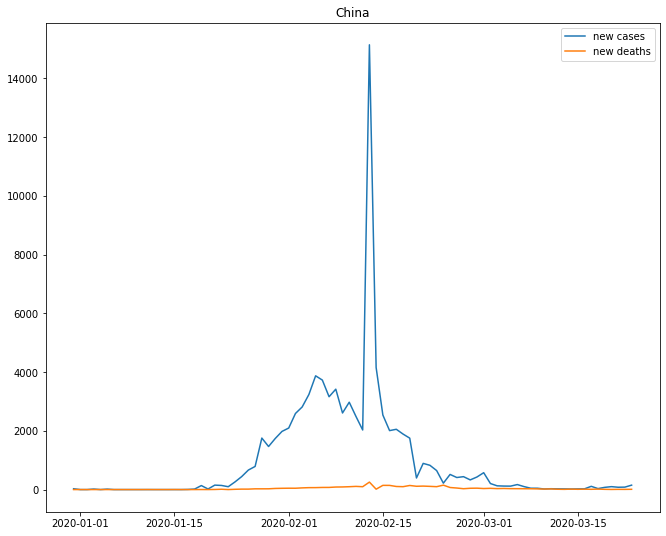

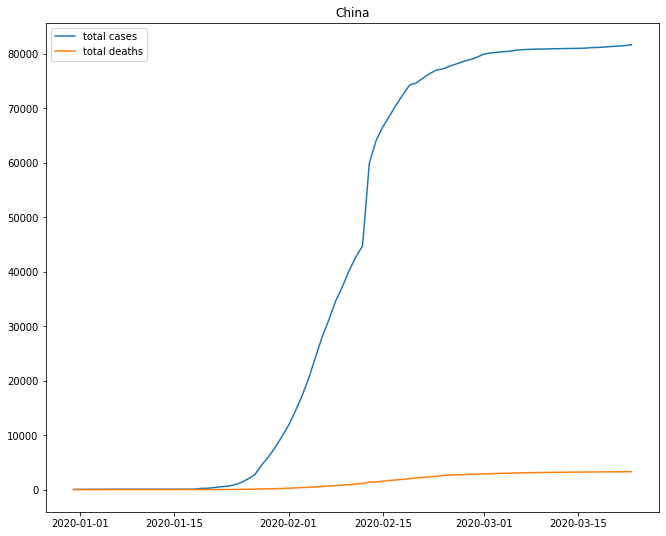

In [201]:
plot_data('China')